In [1]:
!pip install scikit-surprise

     |████████████████████████████████| 3.3MB 2.8MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.0.6-cp36-cp36m-linux_x86_64.whl size=1683502 sha256=7f20f5e09faca6f8bcb1b21deb8828801aae223f3c645d3e44b17c048ad8b36a
  Stored in directory: /root/.cache/pip/wheels/ec/c0/55/3a28eab06b53c220015063ebbdb81213cd3dcbb72c088251ec
Successfully built scikit-surprise


In [0]:
from sklearn.model_selection import ParameterGrid

In [6]:
!pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.21.3)


In [0]:
import pandas as pd
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import *
from surprise.accuracy import rmse, mae, fcp
from UserDefinedAlgorithm import PredictMean
import pickle
from os import listdir

In [10]:
def parse(path):
	g = open(path, 'rb')
	for l in g:
		yield eval(l)
        
#parse data into a pandas dataframe
def get_df(path):
	i = 0
	df = {}
	for d in parse(path):
		df[i] = d
		i += 1
	return pd.DataFrame.from_dict(df, orient='index')

# if the data has been parsed:
#   load it 
# else:
#   parse it, save it and load it
def possibly_get_df(path):
    try:
        df = pd.read_csv('use_item_ratings.csv')
    except IOError:
        df = get_df(path)
        df.to_csv('use_item_ratings.csv', index=False)
    return df

df = possibly_get_df('Clothing_Shoes_and_Jewelry_5.json')
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",This is a great tutu and at a really great pri...,5.0,Great tutu- not cheaply made,1297468800,"02 12, 2011"
1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",I bought this for my 4 yr old daughter for dan...,5.0,Very Cute!!,1358553600,"01 19, 2013"
2,A1RLQXYNCMWRWN,0000031887,Carola,"[0, 0]",What can I say... my daughters have it in oran...,5.0,I have buy more than one,1357257600,"01 4, 2013"
3,A8U3FAMSJVHS5,0000031887,Caromcg,"[0, 0]","We bought several tutus at once, and they are ...",5.0,"Adorable, Sturdy",1398556800,"04 27, 2014"
4,A3GEOILWLK86XM,0000031887,CJ,"[0, 0]",Thank you Halo Heaven great product for Little...,5.0,Grammy's Angels Love it,1394841600,"03 15, 2014"


In [12]:
ratings_df = df[['reviewerID', 'asin','overall']]
print ("Dataframe after dropping unneccessary fields:")
ratings_df.head()

Dataframe after dropping unneccessary fields:


,reviewerID,asin,overall
0,A1KLRMWW2FWPL4,0000031887,5.0
1,A2G5TCU2WDFZ65,0000031887,5.0
2,A1RLQXYNCMWRWN,0000031887,5.0
3,A8U3FAMSJVHS5,0000031887,5.0
4,A3GEOILWLK86XM,0000031887,5.0


In [23]:
total_num_of_ratings = len(ratings_df)
print ("total number of user-items ratings is: ",total_num_of_ratings)

#number of unique reviewers
num_of_users = len(ratings_df['reviewerID'].unique())
print ("number of unique reviewers is:" , num_of_users)

#number of unique items
num_of_items = len(ratings_df['asin'].unique())
print ("number of unique items is:", num_of_items)

#average rating and standar deviation
ratings_mean = ratings_df['overall'].mean()
ratings_std = ratings_df['overall'].std()
print ("average rating  and standard deviation are" ,ratings_mean, ratings_std)

# The sparsity of the user-item matrix
sparsity = float(total_num_of_ratings) / (num_of_users * num_of_items)
print ("sparisity of the user-item matrix is:" , sparsity)

total number of user-items ratings is:  278677
number of unique reviewers is: 39387
number of unique items is: 23033
average rating  and standard deviation are 4.245133254628118 1.1037471651949429
sparisity of the user-item matrix is: 0.0003071833809100676


In [24]:
users_df = ratings_df.groupby('reviewerID').size()
print ("The average number of items rated by a user is" ,np.mean(users_df))
print ("The average number of items rated by a user is" , np.std(users_df))
print ("The minimum number of items rated by a user is" , min(users_df))
print ("The maximum number of items rated by a user is" , max(users_df))

The average number of items rated by a user is 7.075354812501587
The average number of items rated by a user is 3.585204526253403
The minimum number of items rated by a user is 5
The maximum number of items rated by a user is 136


In [25]:
items_df = ratings_df.groupby('asin').size()
print ("The average number of users that rated an item is ",  np.mean(items_df))
print ("The standard deviation of number of users that rated an item is " , np.std(items_df))
print ("The minimum number of users that rated an item is " , min(items_df))
print ("The minimum number of users that rated an item is " , max(items_df))

The average number of users that rated an item is  12.099031823904832
The standard deviation of number of users that rated an item is  13.967951962950204
The minimum number of users that rated an item is  5
The minimum number of users that rated an item is  441


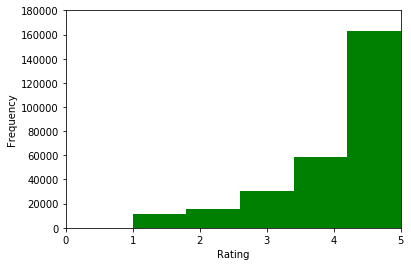

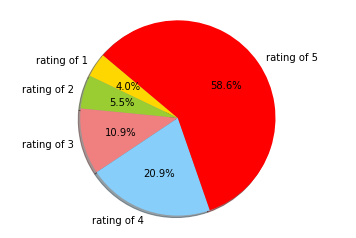

In [26]:
plt.figure(1)
plt.hist(ratings_df['overall'],5, facecolor='g')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.axis([0, 5, 0, 180000])

# percentage of each rating in a pie chart
plt.figure(2)
labels = 'rating of 1', 'rating of 2' ,'rating of 3', 'rating of 4','rating of 5'
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue','red']
plt.pie(ratings_df.groupby('overall').size(),labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')

plt.show()

In [0]:
ratings_df.to_csv('cleaned_user_item_ratings.csv', index=False,header=False)

In [0]:
original_file_path = 'cleaned_user_item_ratings.csv'

reader = Reader(line_format='user item rating', sep=',')
original_data = Dataset.load_from_file(original_file_path, reader=reader)

#Split data into 4 folds, 3 for training and 1 for testing.
original_data.split(n_folds=4)

In [0]:
def algorithm_to_results(data, algo):
    algo = algo()
    alogPerf = evaluate(algo, data,measures=['RMSE', 'FCP'], verbose=False)
    return alogPerf

In [31]:
print (algorithm_to_results(original_data,PredictMean))

/usr/local/lib/python3.6/dist-packages/surprise/prediction_algorithms/algo_base.py:45: UserWarning: It looks like this algorithm (<class 'UserDefinedAlgorithm.PredictMean'>) implements train() instead of fit(): train() is deprecated, please use fit() instead.
  'please use fit() instead.', UserWarning)
/usr/local/lib/python3.6/dist-packages/surprise/evaluate.py:66: UserWarning: The evaluate() method is deprecated. Please use model_selection.cross_validate() instead.
  'model_selection.cross_validate() instead.', UserWarning)
/usr/local/lib/python3.6/dist-packages/surprise/dataset.py:193: UserWarning: Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 
  UserWarning)
/usr/local/lib/python3.6/dist-packages/surprise/prediction_algorithms/algo_base.py:51: UserWarning: train() is deprecated. Use fit() instead
  warnings.warn('train() is deprecated. Use fit() instead', UserWarning)


defaultdict(<class 'list'>, {'rmse': [1.1037445362269522, 1.1035107786722715, 1.1022165120509053, 1.1055234463696018], 'fcp': [0.0, 0.0, 0.0, 0.0]})


In [32]:
print (algorithm_to_results(original_data, SVD))

/usr/local/lib/python3.6/dist-packages/surprise/evaluate.py:66: UserWarning: The evaluate() method is deprecated. Please use model_selection.cross_validate() instead.
  'model_selection.cross_validate() instead.', UserWarning)
/usr/local/lib/python3.6/dist-packages/surprise/dataset.py:193: UserWarning: Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 
  UserWarning)


defaultdict(<class 'list'>, {'rmse': [1.0533529208441688, 1.0534320094877632, 1.049143398394136, 1.0510602068631283], 'fcp': [0.5252986491027677, 0.526070376741988, 0.5185298582673148, 0.5258289248805993]})


In [33]:
print (algorithm_to_results(original_data, CoClustering))

/usr/local/lib/python3.6/dist-packages/surprise/evaluate.py:66: UserWarning: The evaluate() method is deprecated. Please use model_selection.cross_validate() instead.
  'model_selection.cross_validate() instead.', UserWarning)
/usr/local/lib/python3.6/dist-packages/surprise/dataset.py:193: UserWarning: Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 
  UserWarning)


defaultdict(<class 'list'>, {'rmse': [1.177166665432877, 1.1681025564299312, 1.1641494165176016, 1.1718822909752658], 'fcp': [0.515353233857541, 0.5110482602234229, 0.5118714723331239, 0.5136654870048053]})


In [0]:
def get_folds_mean(algo, data, accuracy=['RMSE']):
    measures_list = []
    for trainset, testset in data.folds():
        algo.train(trainset)
        predictions = algo.test(testset)
        accuracy_measure = []
        if 'RMSE' in accuracy:
            accuracy_measure.append(rmse(predictions, verbose=False))
        if 'MAE' in accuracy:
            accuracy_measure.append(mae(predictions, verbose=False))
        if 'FCP' in accuracy:
            accuracy_measure.append(fcp(predictions, verbose=False))
        measures_list.append(accuracy_measure)
    return np.mean(measures_list,axis=0)

# return a list of tuples of each parameter combination and its correcsponding accuracy measure
def compute_all_combinations(combinations_list,algo, data, accuracy=['RMSE']):
    results = []
    for combination in combinations_list:
        algo_instance = algo(**combination)
        mean_accuracy = get_folds_mean(algo_instance, data,accuracy)
        combination['measure'] = mean_accuracy
        results.append(combination)
    return results

In [41]:
print ('regularization is 0.05:')
param_grid = {'n_epochs':[20], 'lr_all': [0.002, 0.005, 0.01, 0.015, 0.02], 'reg_all': [0.05]}
combinations_list  = list(ParameterGrid(param_grid))
vary_lr_rate_only_reg2 = compute_all_combinations(combinations_list, SVD, original_data, accuracy=['RMSE','FCP'])
print ('done')

print ('regularization is 0.1:')
param_grid = {'n_epochs':[20], 'lr_all': [0.002, 0.005, 0.01, 0.015, 0.02], 'reg_all': [0.1]}
combinations_list  = list(ParameterGrid(param_grid))
vary_lr_rate_only_reg3 = compute_all_combinations(combinations_list, SVD, original_data, accuracy=['RMSE','FCP'])
print ('done')

print ('regularization is 0.2:')
param_grid = {'n_epochs':[20], 'lr_all': [0.002, 0.005, 0.01, 0.015, 0.02], 'reg_all': [0.2]}
combinations_list  = list(ParameterGrid(param_grid))
vary_lr_rate_only_reg4 = compute_all_combinations(combinations_list, SVD, original_data, accuracy=['RMSE','FCP'])
print ('done')

print ('regularization is 0.4:')
param_grid = {'n_epochs':[20], 'lr_all': [0.002, 0.005, 0.01, 0.015, 0.02], 'reg_all': [0.4]}
combinations_list  = list(ParameterGrid(param_grid))
vary_lr_rate_only_reg5 = compute_all_combinations(combinations_list, SVD, original_data, accuracy=['RMSE','FCP'])
print ('done')

print ('regularization is 0.6:')
param_grid = {'n_epochs':[20], 'lr_all': [0.002, 0.005, 0.01, 0.015, 0.02], 'reg_all': [0.6]}
combinations_list  = list(ParameterGrid(param_grid))
vary_lr_rate_only_reg6 = compute_all_combinations(combinations_list, SVD, original_data, accuracy=['RMSE','FCP'])
print ('done')

regularization is 0.05:


/usr/local/lib/python3.6/dist-packages/surprise/dataset.py:193: UserWarning: Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 
  UserWarning)
/usr/local/lib/python3.6/dist-packages/surprise/prediction_algorithms/algo_base.py:51: UserWarning: train() is deprecated. Use fit() instead
  warnings.warn('train() is deprecated. Use fit() instead', UserWarning)


done
regularization is 0.1:
done
regularization is 0.2:
done
regularization is 0.4:
done
regularization is 0.6:
done


In [0]:
def get_learn_measure_rmse(iterable):
    x_values = []
    y_values = []
    for item in iterable:
        x_values.append(item['lr_all'])
        y_values.append(item['measure'][0])
    return [x_values, y_values]

def get_learn_measure_fcp(iterable):
    x_values = []
    y_values = []
    for item in iterable:
        x_values.append(item['lr_all'])
        y_values.append(item['measure'][1])
    return [x_values, y_values]

#RMSE
reg2_rmse = get_learn_measure_rmse(vary_lr_rate_only_reg2)
reg3_rmse = get_learn_measure_rmse(vary_lr_rate_only_reg3)
reg4_rmse = get_learn_measure_rmse(vary_lr_rate_only_reg4)
reg5_rmse = get_learn_measure_rmse(vary_lr_rate_only_reg5)
reg6_rmse = get_learn_measure_rmse(vary_lr_rate_only_reg6)

#FCP
reg2_fcp = get_learn_measure_fcp(vary_lr_rate_only_reg2)
reg3_fcp = get_learn_measure_fcp(vary_lr_rate_only_reg3)
reg4_fcp = get_learn_measure_fcp(vary_lr_rate_only_reg4)
reg5_fcp = get_learn_measure_fcp(vary_lr_rate_only_reg5)
reg6_fcp = get_learn_measure_fcp(vary_lr_rate_only_reg6)

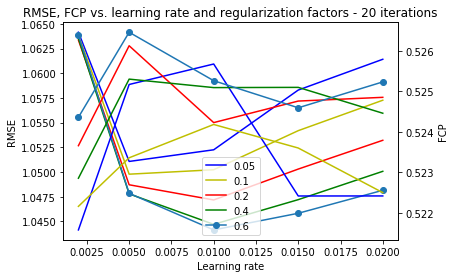

In [44]:
fig, ax1= plt.subplots()
ax1.plot(reg2_rmse[0], reg2_rmse[1], 'b-',reg3_rmse[0], reg3_rmse[1], 'y-',\
         reg4_rmse[0], reg4_rmse[1], 'r-',reg5_rmse[0], reg5_rmse[1], 'g-',reg6_rmse[0], reg6_rmse[1], 'o-')
ax1.set_xlabel('Learning rate')
ax1.set_ylabel('RMSE')
ax2 = ax1.twinx()
ax2.plot(reg2_fcp[0], reg2_fcp[1], 'b-',reg3_fcp[0], reg3_fcp[1], 'y-',\
        reg4_fcp[0], reg4_fcp[1], 'r-',reg5_fcp[0], reg5_fcp[1], 'g-',reg6_fcp[0], reg6_fcp[1], 'o-')
ax2.set_ylabel('FCP')
labels = ['0.05','0.1','0.2','0.4','0.6']
plt.legend(labels)
plt.title('RMSE, FCP vs. learning rate and regularization factors - 20 iterations')
plt.show()

In [46]:
print ('regularization is 0.05:')
param_grid = {'n_epochs':[40], 'lr_all': [0.002, 0.005, 0.01, 0.015, 0.02], 'reg_all': [0.05]}
combinations_list  = list(ParameterGrid(param_grid))
vary_lr_rate_only_reg2_40 = compute_all_combinations(combinations_list, SVD, original_data, accuracy=['RMSE','FCP'])
print ('done')

print ('regularization is 0.1:')
param_grid = {'n_epochs':[40], 'lr_all': [0.002, 0.005, 0.01, 0.015, 0.02], 'reg_all': [0.1]}
combinations_list  = list(ParameterGrid(param_grid))
vary_lr_rate_only_reg3_40 = compute_all_combinations(combinations_list, SVD, original_data, accuracy=['RMSE','FCP'])
print ('done')

print ('regularization is 0.2:')
param_grid = {'n_epochs':[40], 'lr_all': [0.002, 0.005, 0.01, 0.015, 0.02], 'reg_all': [0.2]}
combinations_list  = list(ParameterGrid(param_grid))
vary_lr_rate_only_reg4_40 = compute_all_combinations(combinations_list, SVD, original_data, accuracy=['RMSE','FCP'])
print ('done')

print ('regularization is 0.4:')
param_grid = {'n_epochs':[40], 'lr_all': [0.002, 0.005, 0.01, 0.015, 0.02], 'reg_all': [0.4]}
combinations_list  = list(ParameterGrid(param_grid))
vary_lr_rate_only_reg5_40 = compute_all_combinations(combinations_list, SVD, original_data, accuracy=['RMSE','FCP'])
print ('done')

print ('regularization is 0.6:')
param_grid = {'n_epochs':[40], 'lr_all': [0.002, 0.005, 0.01, 0.015, 0.02], 'reg_all': [0.6]}
combinations_list  = list(ParameterGrid(param_grid))
vary_lr_rate_only_reg6_40 = compute_all_combinations(combinations_list, SVD, original_data, accuracy=['RMSE','FCP'])
print ('done')

regularization is 0.05:


/usr/local/lib/python3.6/dist-packages/surprise/dataset.py:193: UserWarning: Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 
  UserWarning)
/usr/local/lib/python3.6/dist-packages/surprise/prediction_algorithms/algo_base.py:51: UserWarning: train() is deprecated. Use fit() instead
  warnings.warn('train() is deprecated. Use fit() instead', UserWarning)


done
regularization is 0.1:
done
regularization is 0.2:
done
regularization is 0.4:
done
regularization is 0.6:
done


In [0]:
reg2_rmse_40 = get_learn_measure_rmse(vary_lr_rate_only_reg2_40)
reg3_rmse_40 = get_learn_measure_rmse(vary_lr_rate_only_reg3_40)
reg4_rmse_40 = get_learn_measure_rmse(vary_lr_rate_only_reg4_40)
reg5_rmse_40 = get_learn_measure_rmse(vary_lr_rate_only_reg5_40)
reg6_rmse_40 = get_learn_measure_rmse(vary_lr_rate_only_reg6_40)

#FCP
reg2_fcp_40 = get_learn_measure_fcp(vary_lr_rate_only_reg2_40)
reg3_fcp_40 = get_learn_measure_fcp(vary_lr_rate_only_reg3_40)
reg4_fcp_40 = get_learn_measure_fcp(vary_lr_rate_only_reg4_40)
reg5_fcp_40 = get_learn_measure_fcp(vary_lr_rate_only_reg5_40)
reg6_fcp_40 = get_learn_measure_fcp(vary_lr_rate_only_reg6_40)

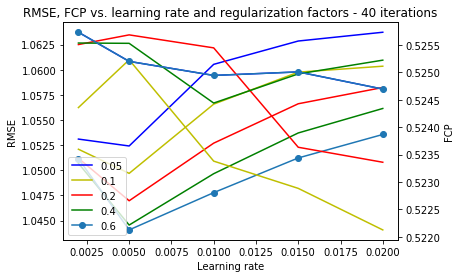

In [48]:
fig, ax1= plt.subplots()
ax1.plot(reg2_rmse_40[0], reg2_rmse_40[1], 'b-', reg3_rmse_40[0], reg3_rmse_40[1], 'y-',\
         reg4_rmse_40[0], reg4_rmse_40[1], 'r-',reg5_rmse_40[0], reg5_rmse_40[1], 'g-',\
         reg6_rmse_40[0], reg6_rmse_40[1], 'o-')
ax1.set_xlabel('Learning rate')
ax1.set_ylabel('RMSE')
ax2 = ax1.twinx()
ax2.plot(reg2_fcp_40[0], reg6_fcp_40[1], 'b-',reg3_fcp_40[0], reg3_fcp_40[1], 'y-',\
        reg2_fcp_40[0], reg4_fcp_40[1], 'r-',reg5_fcp_40[0], reg5_fcp_40[1], 'g-',\
        reg6_fcp_40[0], reg6_fcp_40[1], 'o-')
ax2.set_ylabel('FCP')
labels = ['0.05','0.1','0.2','0.4','0.6']
plt.legend(labels)
plt.title('RMSE, FCP vs. learning rate and regularization factors - 40 iterations')
plt.show()

In [49]:
def svd_algorithm_final(data):
    svdAlgo = SVD(n_epochs=40, lr_all=0.005, reg_all=0.6)
    svdPerf = evaluate(svdAlgo, data, measures=['RMSE', 'FCP'], verbose=False, with_dump=True, dump_dir="./dumps/")
    return svdPerf
print ("Orignal data:")
print (svd_algorithm_final(original_data))

Orignal data:


/usr/local/lib/python3.6/dist-packages/surprise/evaluate.py:66: UserWarning: The evaluate() method is deprecated. Please use model_selection.cross_validate() instead.
  'model_selection.cross_validate() instead.', UserWarning)
/usr/local/lib/python3.6/dist-packages/surprise/dataset.py:193: UserWarning: Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 
  UserWarning)


The dump has been saved as file ./dumps/190810-00h32m14-SVD-fold1
The dump has been saved as file ./dumps/190810-00h32m52-SVD-fold2
The dump has been saved as file ./dumps/190810-00h33m31-SVD-fold3
The dump has been saved as file ./dumps/190810-00h34m10-SVD-fold4
defaultdict(<class 'list'>, {'rmse': [1.0442111506481138, 1.045964627357052, 1.0415518928009093, 1.0444876401253202], 'fcp': [0.5244567590789873, 0.5270248039638017, 0.5207895814010738, 0.5273983670257878]})


In [0]:
# The dump has been saved and we can now use it whenever we want.
# Let's load it and see what we can do
files = listdir("./dumps")
dump_obj = pickle.load(open('./dumps/' + files[0], 'rb'))

In [0]:
# read results from file
predictions = dump_obj['predictions']


In [55]:
print ("Initial dataframe: ")
df = pd.DataFrame(predictions, columns=['user_id', 'item_id', 'actual_rating', 'predicted_rating', 'details']) 
print (df.head())

# We will not use the details field so we will drop it
df.drop('details',axis=1,inplace=True)

print 
print ("After dropping details column: ")
df.head()

Initial dataframe: 
          user_id     item_id  ...  predicted_rating                    details
0   AMRI05KYFSNGE  B0014X6V4Q  ...          3.962407  {'was_impossible': False}
1   A3UKDS0JCJ68Y  B006OW1V4C  ...          4.538245  {'was_impossible': False}
2  A3EQ03LUCUTE6Q  B00B2PMF1Y  ...          4.040201  {'was_impossible': False}
3  A1VCTFBQVZ1F7T  B005P23BB8  ...          3.834530  {'was_impossible': False}
4  A236SEBB7SYE1V  B002NU6MKW  ...          4.435584  {'was_impossible': False}

[5 rows x 5 columns]
After dropping details column: 


,user_id,item_id,actual_rating,predicted_rating
0,AMRI05KYFSNGE,B0014X6V4Q,4.0,3.962407
1,A3UKDS0JCJ68Y,B006OW1V4C,5.0,4.538245
2,A3EQ03LUCUTE6Q,B00B2PMF1Y,5.0,4.040201
3,A1VCTFBQVZ1F7T,B005P23BB8,5.0,3.834530
4,A236SEBB7SYE1V,B002NU6MKW,4.0,4.435584


In [61]:
def get_Iu(uid):
    """Return the number of items rated by given user
    
    Args:
        uid: The raw id of the user.
    Returns:
        The number of items rated by the user.
    """
    
    
    
def get_Ui(iid):
    """Return the number of users that have rated given item
    
    Args:
        iid: The raw id of the item.
    Returns:
        The number of users that have rated the item.
    """
    
    
   
df['user_num_of_ratings'] = df.user_id.apply(get_Iu)
df['item_num_of_ratings'] = df.item_id.apply(get_Ui)
df['mae'] = abs(df.predicted_rating - df.actual_rating)
df.head()

,user_id,item_id,actual_rating,predicted_rating,user_num_of_ratings,item_num_of_ratings,mae
0,AMRI05KYFSNGE,B0014X6V4Q,4.0,3.962407,None,None,0.037593
1,A3UKDS0JCJ68Y,B006OW1V4C,5.0,4.538245,None,None,0.461755
2,A3EQ03LUCUTE6Q,B00B2PMF1Y,5.0,4.040201,None,None,0.959799
3,A1VCTFBQVZ1F7T,B005P23BB8,5.0,3.834530,None,None,1.165470
4,A236SEBB7SYE1V,B002NU6MKW,4.0,4.435584,None,None,0.435584


In [0]:
best_predictions = df.sort_values(by='mae')[:1]
worst_predictions = df.sort_values(by='mae')[-1:]

In [63]:
best_predictions

,user_id,item_id,actual_rating,predicted_rating,user_num_of_ratings,item_num_of_ratings,mae
54248,AMP6MQ78O5OUM,B002HIBZBG,5.0,5.0,None,None,0.0


In [67]:
worst_predictions

,user_id,item_id,actual_rating,predicted_rating,user_num_of_ratings,item_num_of_ratings,mae
21918,AGRGPW2OMOQ52,B000KGI9PM,1.0,4.96112,None,None,3.96112


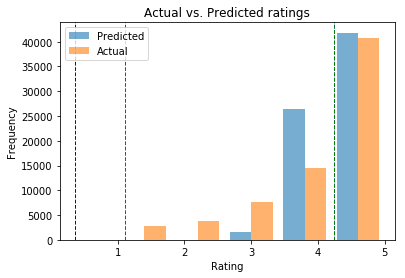

In [70]:
x = df['predicted_rating']
y = df['actual_rating']
data = np.vstack([x, y]).T
plt.hist(data,bins=5,alpha=0.6, label=['Predicted', 'Actual'])
plt.axvline(x.mean(), color='b',linestyle='dashed', linewidth=1)
plt.axvline(x.std(), color='b', linestyle='dashed', linewidth=1)

plt.axvline(y.mean(), color='g', linestyle='dashed',linewidth=1)
plt.axvline(y.std(), color='g', linestyle='dashed', linewidth=1)
plt.legend(loc='upper left')

plt.title("Actual vs. Predicted ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()